<a href="https://colab.research.google.com/github/prp20/PytorchLearning/blob/main/Computer_vision_with_pytorch_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


### Getting Dataset in Pytorch

Download Fashion MNIST dataset from Torchvision.datasets

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform = None

)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform = None

)

100%|██████████| 26421880/26421880 [00:01<00:00, 14334922.93it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211962.66it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3931259.72it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21592276.99it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### Visualizing the data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

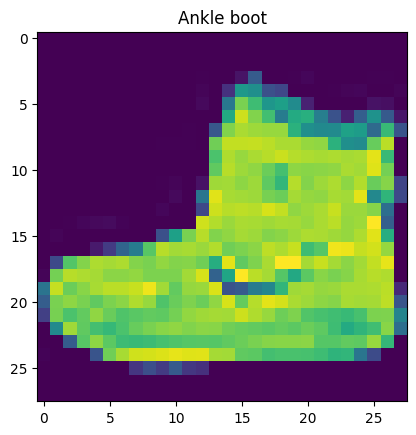

In [7]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(class_names[label])

In [8]:
def display_mnist_images(image, label):
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(class_names[label])

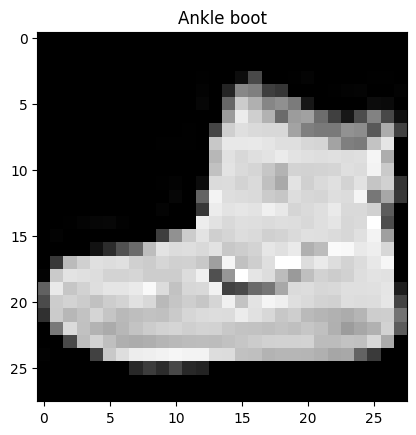

In [9]:
display_mnist_images(image, label)

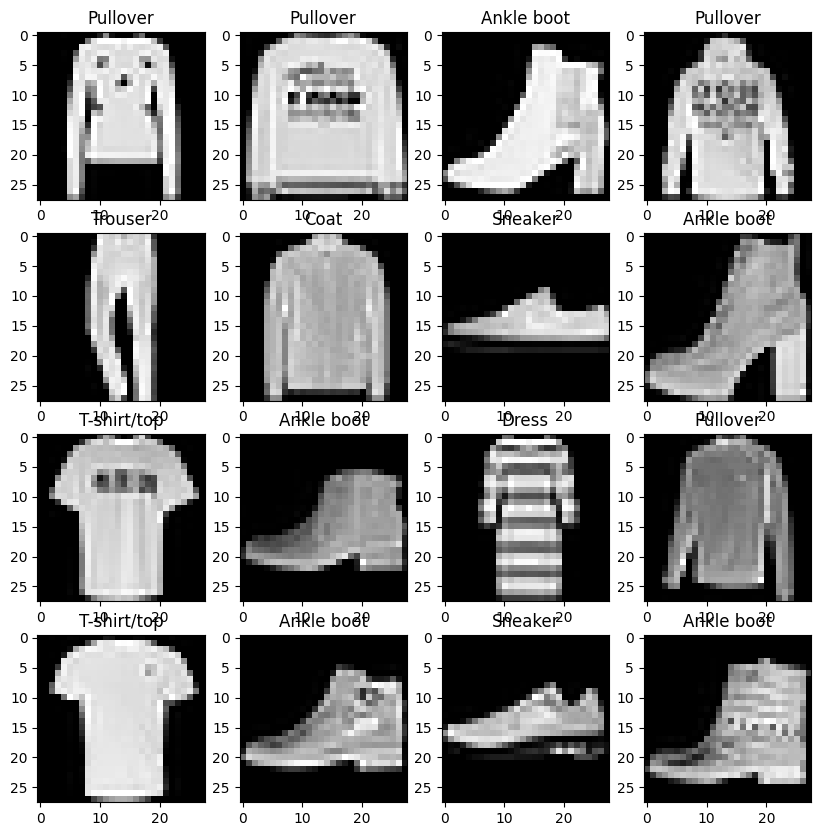

In [10]:
torch.manual_seed = 42
fig = plt.figure(figsize=(10,10))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size =[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis = False


In [11]:
from torch.utils.data import DataLoader

In [12]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset = test_data, batch_size=BATCH_SIZE, shuffle=False)

### Build a Baseline Model

In [13]:
from torch import nn
class BaselineModelV0(nn.Module):
  def __init__(self, input_features:int, hidden_features:int, output_features:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_features, out_features=hidden_features),
        nn.Linear(in_features = hidden_features, out_features=output_features)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [14]:
model_0 = BaselineModelV0(input_features =28*28, hidden_features=100, output_features=10).to(device)
model_0

BaselineModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [15]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("File Exists")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", 'wb') as f:
    f.write(request.content)

In [16]:
from helper_functions import accuracy_fn

In [17]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [18]:
from tqdm.auto import tqdm
import torch

torch.manual_seed = 42
epochs = 10

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = 0, 0
  test_loss, test_acc = 0, 0
  for batch,(X,y) in enumerate(train_dataloader):
    model_0.train()
    X, y = X.to(device), y.to(device)
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    acc = accuracy_fn(y, y_pred.argmax(dim=1))
    train_acc += acc
    optim.zero_grad()
    loss.backward()
    optim.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  model_0.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"Epoch: {epoch}| Training Loss: {train_loss:.2f} | Training Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0| Training Loss: 0.69 | Training Accuracy: 77.87 | Test Loss: 0.65 | Test Accuracy: 78.55
Epoch: 1| Training Loss: 0.67 | Training Accuracy: 79.97 | Test Loss: 0.57 | Test Accuracy: 81.97
Epoch: 2| Training Loss: 0.64 | Training Accuracy: 80.94 | Test Loss: 0.67 | Test Accuracy: 80.66
Epoch: 3| Training Loss: 0.65 | Training Accuracy: 80.95 | Test Loss: 0.62 | Test Accuracy: 80.64
Epoch: 4| Training Loss: 0.64 | Training Accuracy: 81.32 | Test Loss: 0.87 | Test Accuracy: 78.52
Epoch: 5| Training Loss: 0.64 | Training Accuracy: 81.47 | Test Loss: 0.78 | Test Accuracy: 76.93
Epoch: 6| Training Loss: 0.63 | Training Accuracy: 81.76 | Test Loss: 0.61 | Test Accuracy: 81.36
Epoch: 7| Training Loss: 0.63 | Training Accuracy: 81.79 | Test Loss: 0.77 | Test Accuracy: 80.52
Epoch: 8| Training Loss: 0.64 | Training Accuracy: 81.75 | Test Loss: 0.66 | Test Accuracy: 81.61
Epoch: 9| Training Loss: 0.66 | Training Accuracy: 81.67 | Test Loss: 0.93 | Test Accuracy: 79.28


In [19]:
torch.manual_seed = 42
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn:torch.nn.Module, accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test,y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      pred = model(X_test)
      loss += loss_fn(pred, y_test)
      acc += accuracy_fn(y_test, pred.argmax(dim=1))
    loss /= len(test_dataloader)
    acc /= len(test_dataloader)
  return {"model_name":model.__class__.__name__ ,
          "Loss": loss.item(), "Accuracy": acc}


In [20]:
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_results

{'model_name': 'BaselineModelV0',
 'Loss': 0.9289390444755554,
 'Accuracy': 79.28314696485623}

In [21]:
from torch import nn
class BaselineModelV1(nn.Module):
  def __init__(self, input_features:int, hidden_features:int, output_features:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features = hidden_features, out_features=output_features),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

In [22]:
torch.manual_seed = 42
model_1 = BaselineModelV1(input_features =28*28, hidden_features=100, output_features=10).to(device)
model_1

BaselineModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [23]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [24]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_1.parameters(), lr=0.01)

In [25]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optim: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
  train_loss, train_acc = 0, 0
  model.train()
  for batch,(X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

    optim.zero_grad()
    loss.backward()
    optim.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [26]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optim: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test,y_test in dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
  return test_loss, test_acc

In [27]:
from tqdm.auto import tqdm
import torch

torch.manual_seed = 42
epochs = 10

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model_1, train_dataloader, loss_fn, optim, accuracy_fn, device)
  test_loss, test_acc = test_step(model_1, test_dataloader, loss_fn, optim, accuracy_fn, device)
  print(f"Epoch: {epoch}| Training Loss: {train_loss:.2f} | Training Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0| Training Loss: 1.27 | Training Accuracy: 60.71 | Test Loss: 1.19 | Test Accuracy: 64.29
Epoch: 1| Training Loss: 0.97 | Training Accuracy: 72.62 | Test Loss: 0.99 | Test Accuracy: 71.89
Epoch: 2| Training Loss: 0.94 | Training Accuracy: 73.57 | Test Loss: 0.96 | Test Accuracy: 73.34
Epoch: 3| Training Loss: 0.92 | Training Accuracy: 74.02 | Test Loss: 0.96 | Test Accuracy: 73.30
Epoch: 4| Training Loss: 0.91 | Training Accuracy: 74.42 | Test Loss: 0.99 | Test Accuracy: 72.88
Epoch: 5| Training Loss: 0.91 | Training Accuracy: 74.51 | Test Loss: 0.96 | Test Accuracy: 73.59
Epoch: 6| Training Loss: 0.90 | Training Accuracy: 74.77 | Test Loss: 0.95 | Test Accuracy: 74.51
Epoch: 7| Training Loss: 0.90 | Training Accuracy: 74.83 | Test Loss: 0.97 | Test Accuracy: 72.72
Epoch: 8| Training Loss: 0.89 | Training Accuracy: 74.98 | Test Loss: 0.96 | Test Accuracy: 73.50
Epoch: 9| Training Loss: 0.89 | Training Accuracy: 75.08 | Test Loss: 0.94 | Test Accuracy: 74.69


In [28]:
model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn)
model_1_results

{'model_name': 'BaselineModelV1',
 'Loss': 0.9415939450263977,
 'Accuracy': 74.69049520766774}

In [29]:
from torch import nn
class BaselineModelV2(nn.Module):
  def __init__(self, input_features:int, hidden_features:int, output_features:int):
    super().__init__()
    self.conv_layer_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_features,
                  out_channels = hidden_features,
                  kernel_size=3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_features,
                  out_channels = hidden_features,
                  kernel_size=3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_layer_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_features,
                  out_channels = hidden_features,
                  kernel_size=3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_features,
                  out_channels = hidden_features,
                  kernel_size=3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_features*7*7,
                  out_features = output_features)
    )
  def forward(self, x):
    x = self.conv_layer_block_1(x)
    x = self.conv_layer_block_2(x)
    x = self.classifier(x)
    return x

In [30]:
torch.manual_seed = 42
model_2 = BaselineModelV2(input_features =1, hidden_features=10, output_features=10).to(device)
model_2

BaselineModelV2(
  (conv_layer_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [31]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_2.parameters(), lr=0.01)

In [32]:
from tqdm.auto import tqdm
import torch

torch.manual_seed = 42
epochs = 10

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model_2, train_dataloader, loss_fn, optim, accuracy_fn, device)
  test_loss, test_acc = test_step(model_2, test_dataloader, loss_fn, optim, accuracy_fn, device)
  print(f"Epoch: {epoch}| Training Loss: {train_loss:.2f} | Training Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0| Training Loss: 0.48 | Training Accuracy: 82.55 | Test Loss: 0.40 | Test Accuracy: 85.50
Epoch: 1| Training Loss: 0.37 | Training Accuracy: 86.67 | Test Loss: 0.37 | Test Accuracy: 86.32
Epoch: 2| Training Loss: 0.35 | Training Accuracy: 87.13 | Test Loss: 0.38 | Test Accuracy: 86.80
Epoch: 3| Training Loss: 0.34 | Training Accuracy: 87.47 | Test Loss: 0.40 | Test Accuracy: 85.71
Epoch: 4| Training Loss: 0.34 | Training Accuracy: 87.64 | Test Loss: 0.42 | Test Accuracy: 84.87
Epoch: 5| Training Loss: 0.34 | Training Accuracy: 87.77 | Test Loss: 0.39 | Test Accuracy: 87.05
Epoch: 6| Training Loss: 0.33 | Training Accuracy: 87.77 | Test Loss: 0.35 | Test Accuracy: 87.85
Epoch: 7| Training Loss: 0.33 | Training Accuracy: 87.88 | Test Loss: 0.42 | Test Accuracy: 84.95
Epoch: 8| Training Loss: 0.33 | Training Accuracy: 87.80 | Test Loss: 0.36 | Test Accuracy: 86.99
Epoch: 9| Training Loss: 0.33 | Training Accuracy: 87.70 | Test Loss: 0.36 | Test Accuracy: 87.17


In [33]:
model_2_results = eval_model(model_2, test_dataloader, loss_fn, accuracy_fn)
model_2_results

{'model_name': 'BaselineModelV2',
 'Loss': 0.35767820477485657,
 'Accuracy': 87.17052715654953}

In [34]:
import pandas as pd
compare_results = pd.DataFrame([
    model_0_results,model_1_results,model_2_results
])
compare_results

,model_name,Loss,Accuracy
0,BaselineModelV0,0.928939,79.283147
1,BaselineModelV1,0.941594,74.690495
2,BaselineModelV2,0.357678,87.170527


In [35]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device:torch.device=device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

In [36]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

In [37]:
pred_probs = make_predictions(model_2, test_samples)
pred_clasases = pred_probs.argmax(dim=1)

In [38]:
pred_clasases

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

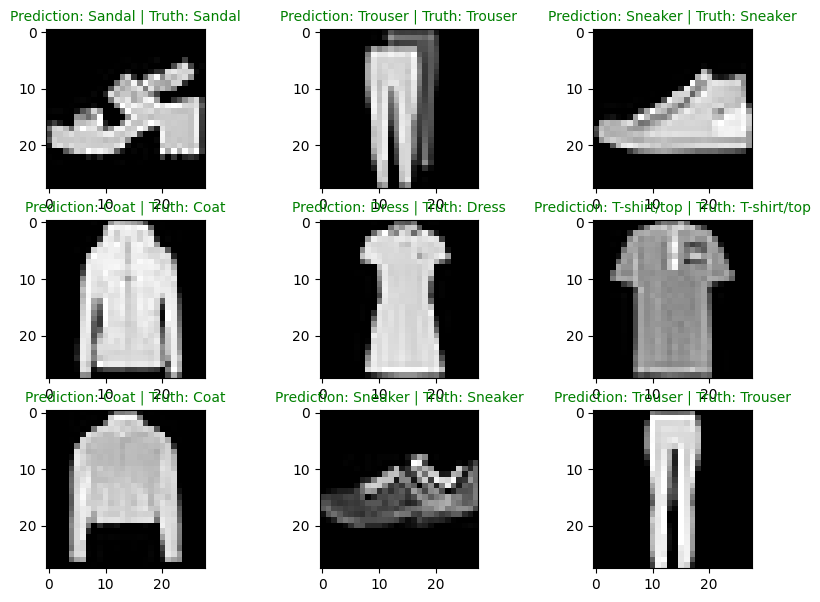

In [39]:
plt.figure(figsize=(10,7))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_clasases[i]]
  truth_label = class_names[test_labels[i]]
  title_text = f"Prediction: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis = True;


In [40]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  print(f"torchmetrics version: {torchmetrics.__version__}")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  print(f"torchmetrics version: {torchmetrics.__version__}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.9 MB/s eta 0:00:00
mlxtend version: 0.22.0
torchmetrics version: 1.2.0


In [41]:
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc = "Making Predictions..."):
    X_test, y_test = X.to(device), y.to(device)
    y_logit = model_2(X_test)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor.shape


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000])

In [42]:
test_data.targets.shape

torch.Size([10000])

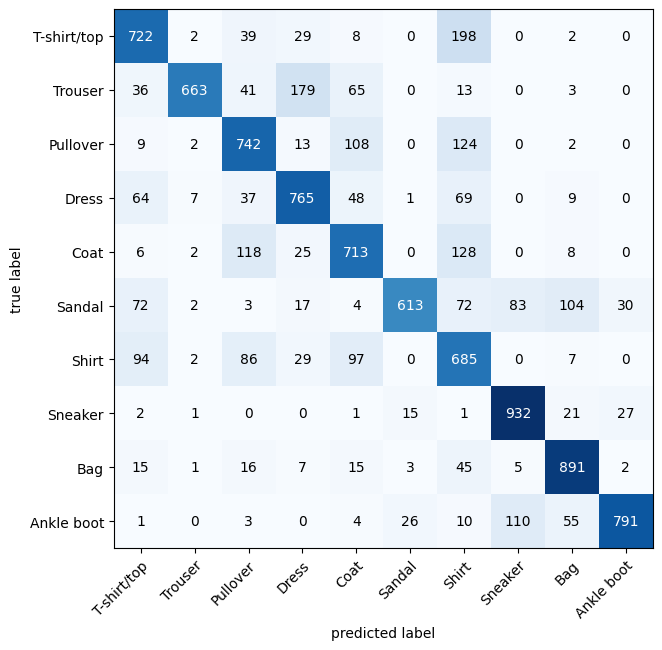

In [43]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes = len(class_names))
confmat_tensor = confmat(y_pred_tensor, test_data.targets)

fig, ax  = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), class_names = class_names, figsize=(10, 7))

In [44]:
confmat_tensor

tensor([[722,   2,  39,  29,   8,   0, 198,   0,   2,   0],
        [ 36, 663,  41, 179,  65,   0,  13,   0,   3,   0],
        [  9,   2, 742,  13, 108,   0, 124,   0,   2,   0],
        [ 64,   7,  37, 765,  48,   1,  69,   0,   9,   0],
        [  6,   2, 118,  25, 713,   0, 128,   0,   8,   0],
        [ 72,   2,   3,  17,   4, 613,  72,  83, 104,  30],
        [ 94,   2,  86,  29,  97,   0, 685,   0,   7,   0],
        [  2,   1,   0,   0,   1,  15,   1, 932,  21,  27],
        [ 15,   1,  16,   7,  15,   3,  45,   5, 891,   2],
        [  1,   0,   3,   0,   4,  26,  10, 110,  55, 791]])

In [45]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)
model_name = "03_basic_pytorch_conputer_vision.pth"
MODEL_SAVE_PATH = model_path / model_name
MODEL_SAVE_PATH

PosixPath('models/03_basic_pytorch_conputer_vision.pth')

In [46]:
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

In [48]:
torch.manual_seed = 42
loaded_model_02 = BaselineModelV2(input_features =1, hidden_features=10, output_features=10).to(device)
loaded_model_02.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [50]:
model_2_results

{'model_name': 'BaselineModelV2',
 'Loss': 0.35767820477485657,
 'Accuracy': 87.17052715654953}

In [51]:
torch.manual_seed = 42
loaded_model_results = eval_model(loaded_model_02, test_dataloader, loss_fn, accuracy_fn )

In [52]:
loaded_model_results

{'model_name': 'BaselineModelV2',
 'Loss': 0.35767820477485657,
 'Accuracy': 87.17052715654953}